# face detection using Tensorflow

In [102]:
import sys
import time
import os
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import cv2
import functions as fn
import webcolors

sys.path.append("./")
sys.path.append("./utils/")
sys.path.append("./protos/")
import label_map_util
import visualization_utils_color as vis_util

disp_height=1080/1.55
disp_width=1920/1.55

try:
    import google.colab
    IN_COLAB = True
    %matplotlib inline
    from google.colab import drive
    from google.colab.patches import cv2_imshow
    drive.mount('/content/gdrive')
    DRIVE_ROOT='/content/gdrive/My Drive/opencv/'
    !pip install face_recognition
except:
    IN_COLAB =False
    %matplotlib notebook  
    DRIVE_ROOT='./'
PATH_TO_CKPT = os.path.join(DRIVE_ROOT,'model/frozen_inference_graph_face.pb')
PATH_TO_LABELS = os.path.join(DRIVE_ROOT,'protos/face_label_map.pbtxt')

NUM_CLASSES = 2

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map,max_num_classes=NUM_CLASSES,use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
    (im_width,im_height) = image.size
    return np.array(image.getdata()).reshape((im_height,im_width, 3)).astype(np.uint8)


In [11]:
cap = cv2.VideoCapture('./gassou_30sec_large.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
interval,time_wait = fn.getInterval(fps)
out = None
print('w:',width,'h:',height)

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
with detection_graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(graph=detection_graph, config=config) as sess:
        frame_num = 1490
        while frame_num:
            frame_num-=1
            ret, image = cap.read()
            if ret == 0:
                break
            if out is None:
                #[h,w] = image.shape[:2]
                fourcc = cv2.VideoWriter_fourcc(*'DIVX')
                #out = cv2.VideoWriter("./media/test_out.avi", 0,25.0, (w,h))
                out = cv2.VideoWriter("./media/test_out.avi", fourcc, fps, (width, height))

            image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image_np_expanded = np.expand_dims(image_np,axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            start_time = time.time()
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes,scores,classes,num_detections],
                feed_dict={image_tensor: image_np_expanded}
            )
            elapsed_time = time.time() - start_time
            #print('inteference time cost: {}'.format(elapsed_time))
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=2
            )
            out.write(image)
            image=cv2.resize(image,(960,540))
            cv2.imshow("detect_by_tensorflow",image)
            k=cv2.waitKey(time_wait) & 0xFF
            if k==27:
                break;

        cv2.destroyAllWindows()
        cap.release()
        out.release()

interval:  0.04170833333333333 time_wait:  41
w: 1280 h: 720


In [71]:
import face_recognition
known_face_names = []
known_face_encodings = []

def scan_known_faces(known_people_folder):
    image_files_in_folder = os.listdir(known_people_folder)
    for name in image_files_in_folder:
        if name.startswith("."):
            continue
        file=os.path.join(known_people_folder,name)
        basename = os.path.splitext(os.path.basename(file))[0]
        img = face_recognition.load_image_file(file)
        encodings = face_recognition.face_encodings(img)

        if len(encodings) > 1:
            click.echo("WARNING: More than one face found in {}. Only considering the first face.".format(file))

        if len(encodings) == 0:
            click.echo("WARNING: No faces found in {}. Ignoring file.".format(file))
        else:
            known_face_names.append(basename)
            known_face_encodings.append(encodings[0])

    return known_face_names, known_face_encodings

scan_known_faces('./known_face/')            
print(known_face_names)

['Asako', 'Aya', 'ClassMate1', 'ClassMate2', 'Girl1', 'Jiro', 'Saki', 'Suzu', 'Toma']


inteference time cost: 2.5270466804504395
w 1478 h 1108
r 0.6288575754046815
w 929 h 696


<IPython.core.display.Javascript object>


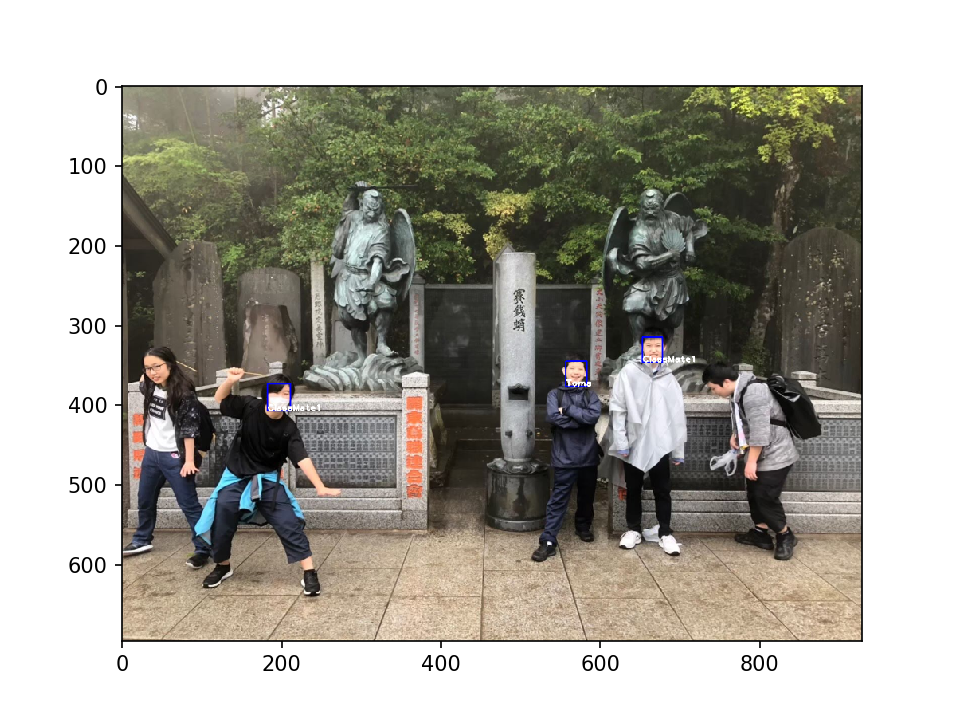

In [103]:
def calc_resize(image):
    im_height,im_width = image.shape[:2]
    print('w',im_width,'h',im_height)
    if im_height>disp_height or im_width>disp_width:
        r =min(disp_height/im_height,disp_width/im_width)
        print('r',r)
        im_height=int(im_height*r)
        im_width=int(im_width*r)
    print('w',im_width,'h',im_height)
    return (im_width,im_height)

def recognize(image,face_locations,threshold=0.6):
    face_names=[]
    frame = image[:,:,::-1]
    face_encodings = face_recognition.face_encodings(image,face_locations)
    for face_encoding in face_encodings:
        matches = face_recognition.compare_faces(known_face_encodings,face_encoding)
        name = 'known'
        
        face_distance = face_recognition.face_distance(known_face_encodings,face_encoding)
        best_match_index = np.argmin(face_distance)
        if matches[best_match_index]:
            if face_distance[best_match_index]<threshold:
                name = known_face_names[best_match_index]
            else:
                name = '?'+known_face_names[best_match_index]+'?'
        face_names.append(name)
    return face_names

def name_to_bgr(name):
    (r,g,b)=webcolors.name_to_rgb(name)
    return (b,g,r)

def get_detection_graph():
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

def boxes_to_face_locations(boxes,scores,image_height,image_width,threshold=0.7):
    # print('threshold',threshold,'boxes',len(boxes))
    face_locations=[]
    for i in range(len(boxes)):
        if scores[i]>threshold:
            #print(i,scores[i])
            ymin,xmin,ymax,xmax = boxes[i]
            top = int(image_height*ymin)
            left=int(image_width*xmin)
            bottom=int(image_height*ymax)
            right=int(image_width*xmax)
            face_locations.append((top,right,bottom,left))
            #(top,right,bottom,left)=face_location;
    #print('face_locations',len(face_locations))
    return face_locations

def detect_face_tf(image):
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 1.2
    thickness = 2
    detection_graph=get_detection_graph()
    with detection_graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(graph=detection_graph, config=config) as sess:
            image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image_np_expanded = np.expand_dims(image_np,axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            start_time = time.time()
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes,scores,classes,num_detections],
                feed_dict={image_tensor: image_np_expanded}
            )
            elapsed_time = time.time() - start_time
            print('inteference time cost: {}'.format(elapsed_time))
            # vis_util.visualize_boxes_and_labels_on_image_array(
            #    image,
            #    np.squeeze(boxes),
            #    np.squeeze(classes).astype(np.int32),
            #    np.squeeze(scores),
            #    category_index,
            #    use_normalized_coordinates=True,
            #    line_thickness=2
            #)
            boxes=np.squeeze(boxes)
            scores=np.squeeze(scores)
            classes=np.squeeze(classes)
            im_height,im_width = image.shape[:2]
            
            face_locations = boxes_to_face_locations(boxes,scores,im_height,im_width)
            face_names=recognize(image,face_locations)
            for i in range(len(face_locations)):
            #for i in range(len(boxes)):
                face_location=face_locations[i]
                #class_name = category_index[classes[i]]['name']
                
                #print('box:',boxes[i],'score:',scores[i],class_name)
                #if scores[i]>0.7:
                #    c=get_color('red')
                #elif scores[i]>0.1:
                #    c=get_color('blue')
                #else:
                #    c=get_color('gray')
                #ymin,xmin,ymax,xmax = boxes[i]
                #top = int(im_height*ymin)
                #left=int(im_width*xmin)
                #bottom=int(im_height*ymax)
                #right=int(im_width*xmax)
                (top,right,bottom,left)=face_location;
                cv2.rectangle(image, (left,top), (right,bottom), name_to_bgr('blue'),2)
                cv2.putText(image, face_names[i], (left,bottom), font,font_scale, (255,255,255), thickness)
#file_name="./test-data/img_report.jpg"
file_name="./test-data/IMG_6003.jpg"
image = cv2.imread(file_name)
detect_face_tf(image)

sz = calc_resize(image)
image=cv2.resize(image,sz)
cv2.imshow("test",image)

image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cv2.waitKey(0) & 0xFF
cv2.destroyAllWindows()